<a href="https://colab.research.google.com/github/06yako14/stock-prediction/blob/dev/TimeSeriesModels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 時系列モデルによる日経平均株価予測

## 概要
2024年1月より新NISAの開始に伴い、株式投資への機運が高まっている。<br>
業務で触れている機械学習や統計解析をもとに日経平均株価の予測を行う。

## 実装

### 使用ライブラリのインポート

In [1]:
import datetime
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
!pip install japanize_matplotlib
import japanize_matplotlib
import seaborn as sns

import yfinance as yf

# 予測モデル
# 自己回帰モデル
# !pip install statsmodels
from statsmodels.tsa.ar_model import AutoReg

from sklearn.metrics import mean_squared_error

# Pandasのオプション
pd.options.display.max_columns=100
pd.options.display.max_rows=50

%matplotlib inline

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 24.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize_matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=426094549ce5b963ab18f71e2b0b9238f45e0a3b652940e59926a852e96fa9b3
  Stored in directory: /root/.cache/pip/wheels/61/7a/6b/df1f79be9c59862525070e157e62b08eab8ece27c1b68fbb94
Successfully built japanize_matplotlib


### データの読み込み

In [2]:
# 取得日付を指定
# start = detatime.datetime(1965, 1, 5) # yfinanceに保存されているデータの開始日
# end = datetime.datetime.today()

In [3]:
# 株（指標）の銘柄コード、ティッカーシンボルの設定
# 今回は日経平均株価
stock_code = '^N225'

In [4]:
# 株価取得
# nikkei = yf.downlod(tickers=stock_code, start=start, end=end)
nikkei = yf.download(tickers=stock_code)

[*********************100%%**********************]  1 of 1 completed


### データの確認

In [5]:
nikkei

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1965-01-05,1257.719971,1257.719971,1257.719971,1257.719971,1257.719971,0
1965-01-06,1263.989990,1263.989990,1263.989990,1263.989990,1263.989990,0
1965-01-07,1274.270020,1274.270020,1274.270020,1274.270020,1274.270020,0
1965-01-08,1286.430054,1286.430054,1286.430054,1286.430054,1286.430054,0
1965-01-12,1288.540039,1288.540039,1288.540039,1288.540039,1288.540039,0
...,...,...,...,...,...,...
2024-07-12,41668.859375,41754.761719,41188.289062,41190.679688,41190.679688,130400000
2024-07-16,41366.789062,41520.070312,41220.648438,41275.078125,41275.078125,100800000
2024-07-17,41416.179688,41466.449219,41054.718750,41097.691406,41097.691406,109900000


### 欠損値の確認

In [6]:
nikkei.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

### データの可視化

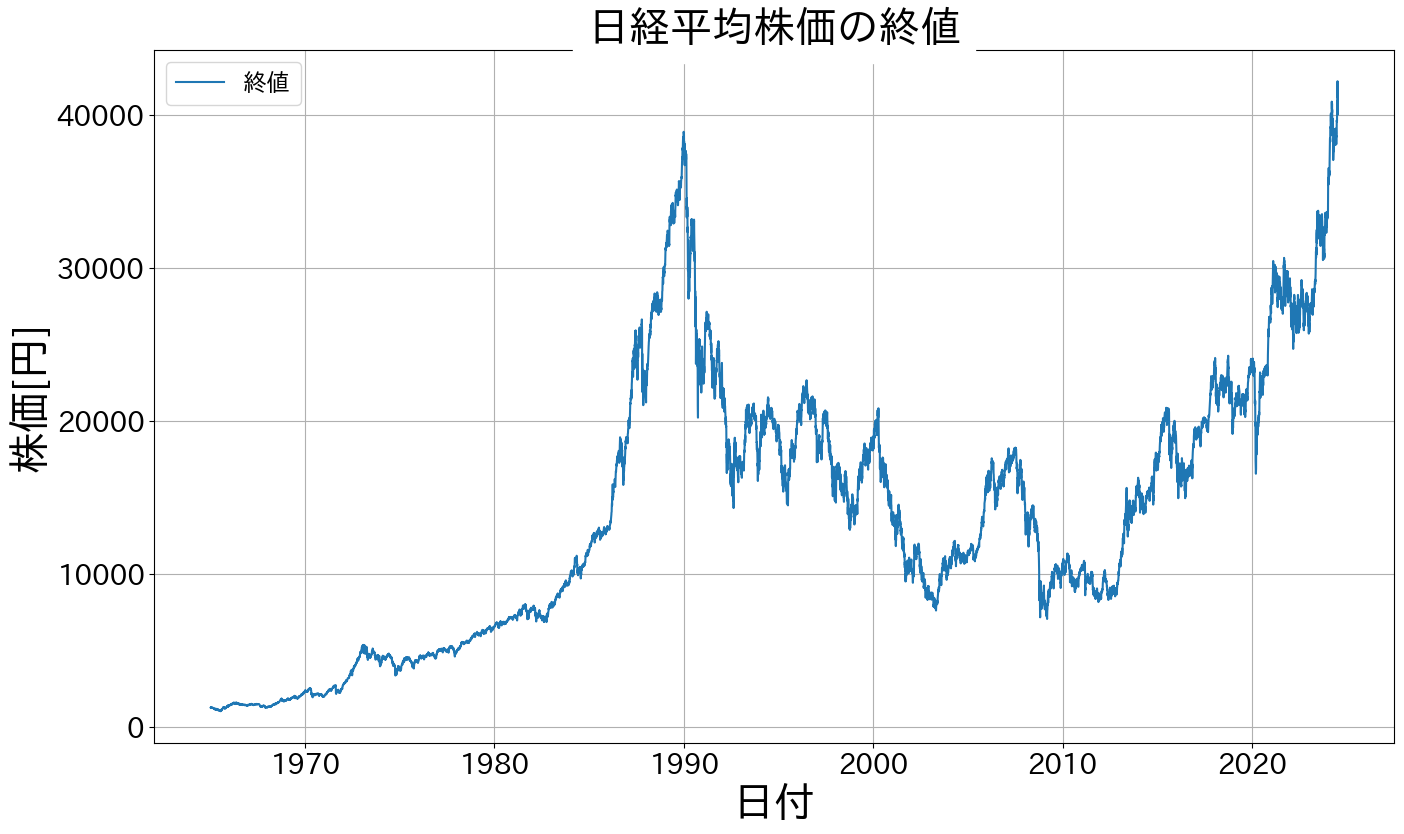

In [7]:
plt.figure(figsize=(16, 9))
plt.plot(nikkei.index, nikkei['Close'], label="終値")
plt.title('日経平均株価の終値', color='black', backgroundcolor='white', size=30, loc='center', fontname='IPAexGothic')
plt.xlabel('日付', color='black', size=30, fontname='IPAexGothic')
plt.ylabel('株価[円]', color='black', size=30, fontname='IPAexGothic')
plt.xticks(size=20)
plt.yticks(size=20)

plt.legend(loc="upper left", prop={'family': 'IPAexGothic', 'size':'xx-large'})
plt.grid()
plt.show()

### データセット作成

In [8]:
# 訓練データを準備
train_df = nikkei[:'2024-05-23']

In [9]:
train_df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1965-01-05,1257.719971,1257.719971,1257.719971,1257.719971,1257.719971,0
1965-01-06,1263.989990,1263.989990,1263.989990,1263.989990,1263.989990,0
1965-01-07,1274.270020,1274.270020,1274.270020,1274.270020,1274.270020,0
1965-01-08,1286.430054,1286.430054,1286.430054,1286.430054,1286.430054,0
1965-01-12,1288.540039,1288.540039,1288.540039,1288.540039,1288.540039,0
...,...,...,...,...,...,...
2024-05-17,38561.039062,38842.488281,38539.558594,38787.378906,38787.378906,133300000
2024-05-20,38761.710938,39437.160156,38703.699219,39069.679688,39069.679688,127400000
2024-05-21,39232.160156,39346.148438,38942.281250,38946.929688,38946.929688,106700000


### モデル構築

In [10]:
# 過去30営業日を入力とする
min_lag = 30

# 5営業日先まで予測させる
len_test = 5

In [11]:
# モデルの学習
ar_model = AutoReg(train_df['Close'], lags=min_lag).fit()

0        39103.218750
14603    39033.683749
14604    39062.420704
14605    39055.837976
14606    39090.488318
14607    39055.275438
14608    39088.258431
dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the po

In [ ]:
# 予測
train_predict = ar_model.predict(start=len(train_df) - 30 + 1, end=len(train_df))
test_predict = ar_model.predict(start=len(train_df) + 1, end=len(train_df) + len_test + 1)

previous = pd.Series([train_df['Close'].iloc[-1]])
test_predict = pd.concat([previous, test_predict])

print(test_predict)

In [12]:
# 比較用データフレーム作成
date_index = ['2024-5-23', '2024-5-24', '2024-5-27', '2024-5-28', '2024-5-29', '2024-5-30', '2024-5-31']

train_predict_df = pd.DataFrame({'Date':                train_df.tail(30).index,
                                 'Train_predicted':     train_predict
                                 }).set_index('Date')

test_predict_df = pd.DataFrame({'Date':             date_index,
                                'Test_predicted':   test_predict
                                })

predict_df = pd.concat([train_predict_df, test_predict_df])

In [15]:
predict_df

,Train_predicted,Date,Test_predicted
2024-04-09 00:00:00,39790.367227,NaN,NaN
2024-04-10 00:00:00,39576.278800,NaN,NaN
2024-04-11 00:00:00,39448.422884,NaN,NaN
2024-04-12 00:00:00,39520.393981,NaN,NaN
2024-04-15 00:00:00,39167.748108,NaN,NaN
2024-04-16 00:00:00,38433.229740,NaN,NaN
2024-04-17 00:00:00,37951.003358,NaN,NaN
2024-04-18 00:00:00,38078.030803,NaN,NaN
2024-04-19 00:00:00,37082.980328,NaN,NaN
2024-04-22 00:00:00,37510.700384,NaN,NaN


### 可視化

TypeError: 'value' must be an instance of str or bytes, not a float

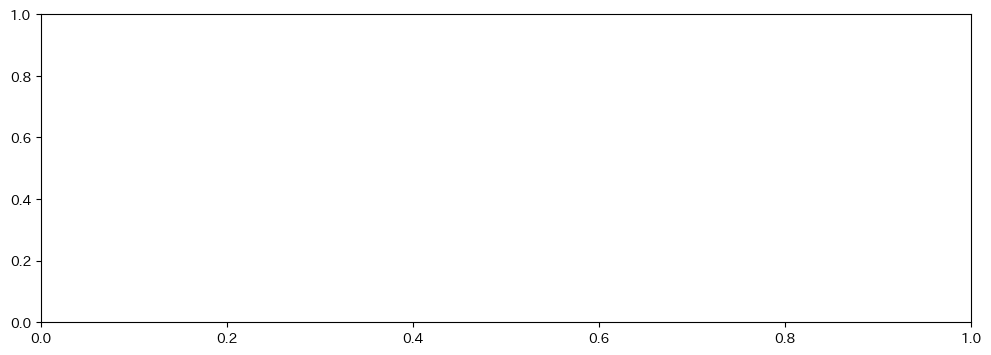

In [16]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(predict_df['Date'], predict_df['Test_predicted'], ls='-', marker='o', color='tab:orange', label='予測')
# ax.plot(predict_df.index, predict_df['Train_predicted'], ls='-', marker='o', color='tab:blue', label='訓練')
ax.legend()
plt.show()